In [1]:
#https://skillmemory.tistory.com/entry/tqdm-%EC%82%AC%EC%9A%A9%EB%B2%95-python-%EC%A7%84%ED%96%89%EB%A5%A0-%ED%94%84%EB%A1%9C%EC%84%B8%EC%8A%A4%EB%B0%94
#https://deep-learning-study.tistory.com/459
#https://honeyjamtech.tistory.com/40
#https://colab.research.google.com/github/kjamithash/Pytorch_DeepLearning_Experiments/blob/master/FashionMNIST_ResNet_TransferLearning.ipynb#scrollTo=m05rFpG5f5yn
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=mnist

## MNIST 분류기 모델 작성 -> Resnet 이용
1. dataload(dataset, dataloader)
1. model layer 만들기 
1. 학습코드(earlystopping)
1. tensorboard 기록

## download data & dataloader

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

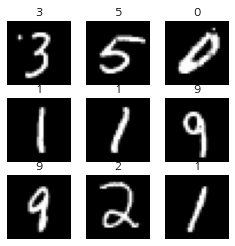

In [3]:
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3
for i in range(0, cols * rows ):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset,DataLoader
# generate indices: instead of the actual data we pass in integers instead
VAL_SIZE = 0.2

train_indices, val_indices, _, _ = train_test_split(
    range(len(training_data)),
    training_data.targets,
    stratify=training_data.targets,
    test_size=VAL_SIZE,
)

# generate subset based on indices
train_split = Subset(training_data, train_indices)
val_split = Subset(training_data, val_indices)

# create batches
train_dataloader = DataLoader(train_split, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_split, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


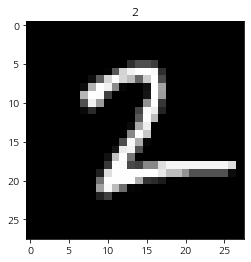

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[32].permute(1,2,0)
label = train_labels[32]
plt.title(label.item())
plt.imshow(img, cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


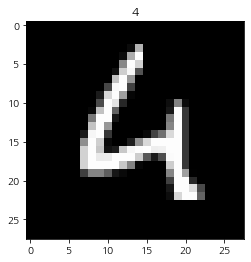

In [6]:
val_features, val_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}")
img = val_features[32].permute(1,2,0)
label = val_labels[32]
plt.title(label.item())
plt.imshow(img, cmap="gray")
plt.show()

## model 정의

In [7]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms

In [8]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:1 device


In [9]:
class MNISTResNet(nn.Module):
    def __init__(self, model,in_channels=1, num_classes=10):
        super(MNISTResNet, self).__init__()
        self.model=model
        self.num_classes=num_classes
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
        # Change the output layer to output 10 classes instead of 1000 classes
        fc_in = self.model.fc.in_features
        self.model.fc = nn.Linear(fc_in, 10)

    def forward(self, x):
        return self.model(x)

model=models.resnet50(pretrained=False)
model = MNISTResNet(model)


In [10]:
model

MNISTResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [11]:
from torchsummary import summary
model=model.to(device)
summary(model, input_size=(1, 28, 28))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper__cudnn_convolution)

## training
1. earlystopping
1. 에포크 단위(100) 업뎃-> 한 에폭에서 미니 배치 마다 학습
    -> 미니 배치마다 

In [16]:
epoches = 100

# loss function and optimiyer
loss_fn = nn.CrossEntropyLoss() 

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

loss_list= []
acc_list=[]
batches = len(train_dataloader)
val_batches = len(test_dataloader)

In [17]:
import numpy as np

class EarlyStopping:
    def __init__(self,patience=10, verbose=True, delta=0, path='checkpoint2/checkpoint.pt'):
        self.patience=patience
        self.verbose=verbose
        self.counter=0
        self.best_score = None
        self.early_stop=False
        self.val_loss_min = np.Inf
        self.delta=delta
        self.path=path
    
    def save_checkpoint(self,val_loss,model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
    
    def __call__(self, val_loss, model):
        score =- val_loss
        
        if self.best_score is None:
            self.best_score=score
            self.save_checkpoint(val_loss,model)
        
        elif self.best_score+self.delta>score:
            self.counter+=1
            print('Earlystopping 동작: {0} out of {1}'.format(self.counter,self.patience))
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.save_checkpoint(val_loss,model)
            self.counter=0

In [19]:
#학습코드 정의
from tqdm import tqdm
import time

early_stopping = EarlyStopping(patience=10 ,verbose=True)

for epoch in range(epoches): #에포크 업데이트
        
    print(f"epoch: {epoch}")
    tr_correct=0
    tr_losses=0
    process=tqdm((train_dataloader))
    ################학습######################
    for X,y in process:
        X=X.to(device)
        output=model(X)
        y=y.to(device)
        tr_loss=loss_fn(output, y)
        tr_losses=+tr_loss.item()
        
        # 역전파
        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()
        
        #acc 계산
        tr_correct += (output.argmax(1) == y).type(torch.float).sum().item()
    
    tr_losses/= len(train_dataloader)
    tr_acc = tr_correct/len(train_dataloader.dataset) 

    #loss 표시
    process.set_description("Loss: {:.4f}".format(tr_losses))
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    correct=0
    precision, recall, f1, accuracy = [], [], [], []
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(val_dataloader):
            X=X.to(device)
            y=y.to(device)
            output = model(X) 
            val_losses=+loss_fn(output, y).item()
            #acc 계산
            correct += (output.argmax(1) == y).type(torch.float).sum().item()
        
    val_losses/=len(val_dataloader) 
    acc=correct/len(val_dataloader.dataset)  
    
    early_stopping(val_losses,model)
    loss_list.append(val_losses)
    acc_list.append(acc)

    if early_stopping.early_stop==True:
        print("Early stopping !")
        break
    #print(f"Epoch {epoch+1}/{epochs}, training acc: {tr_acc}, validation acc: {acc}")
print("DONE")

epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 46.83it/s]


Validation loss decreased (inf --> 0.001231).  Saving model ...
epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.32it/s]


Validation loss decreased (0.001231 --> 0.000330).  Saving model ...
epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.95it/s]


Earlystopping 동작: 1 out of 10
epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.50it/s]


Earlystopping 동작: 2 out of 10
epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:05<00:00, 36.23it/s]


Earlystopping 동작: 3 out of 10
epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 38.20it/s]


Validation loss decreased (0.000330 --> 0.000018).  Saving model ...
epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.20it/s]


Earlystopping 동작: 1 out of 10
epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:05<00:00, 31.96it/s]


Earlystopping 동작: 2 out of 10
epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.22it/s]


Earlystopping 동작: 3 out of 10
epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.44it/s]


Earlystopping 동작: 4 out of 10
epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.74it/s]


Earlystopping 동작: 5 out of 10
epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.94it/s]


Earlystopping 동작: 6 out of 10
epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.81it/s]


Validation loss decreased (0.000018 --> 0.000008).  Saving model ...
epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.24it/s]


Validation loss decreased (0.000008 --> 0.000006).  Saving model ...
epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.69it/s]


Earlystopping 동작: 1 out of 10
epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 43.41it/s]


Earlystopping 동작: 2 out of 10
epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.94it/s]


Earlystopping 동작: 3 out of 10
epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.12it/s]


Earlystopping 동작: 4 out of 10
epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.45it/s]


Earlystopping 동작: 5 out of 10
epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.06it/s]


Earlystopping 동작: 6 out of 10
epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 38.97it/s]


Earlystopping 동작: 7 out of 10
epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.81it/s]


Validation loss decreased (0.000006 --> 0.000004).  Saving model ...
epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.74it/s]


Earlystopping 동작: 1 out of 10
epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.72it/s]


Earlystopping 동작: 2 out of 10
epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.02it/s]


Validation loss decreased (0.000004 --> 0.000002).  Saving model ...
epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.96it/s]


Earlystopping 동작: 1 out of 10
epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.61it/s]


Earlystopping 동작: 2 out of 10
epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.04it/s]


Validation loss decreased (0.000002 --> 0.000000).  Saving model ...
epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 37.63it/s]


Earlystopping 동작: 1 out of 10
epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.57it/s]


Earlystopping 동작: 2 out of 10
epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.99it/s]


Earlystopping 동작: 3 out of 10
epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 42.86it/s]


Earlystopping 동작: 4 out of 10
epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.97it/s]


Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.04it/s]


Earlystopping 동작: 1 out of 10
epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 42.01it/s]


Earlystopping 동작: 2 out of 10
epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 38.80it/s]


Earlystopping 동작: 3 out of 10
epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:05<00:00, 35.61it/s]


Earlystopping 동작: 4 out of 10
epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:06<00:00, 28.72it/s]


Earlystopping 동작: 5 out of 10
epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.50it/s]


Earlystopping 동작: 6 out of 10
epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 40.63it/s]


Earlystopping 동작: 7 out of 10
epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.17it/s]


Earlystopping 동작: 8 out of 10
epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.40it/s]


Earlystopping 동작: 9 out of 10
epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 41.01it/s]

Earlystopping 동작: 10 out of 10
Early stopping !
DONE


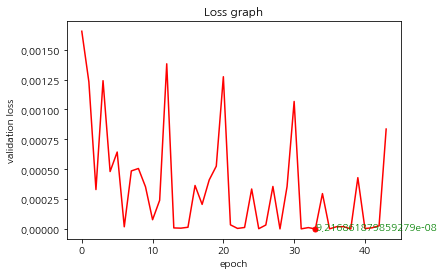

In [21]:
xrange=range(len(loss_list))
plt.plot(xrange,loss_list, "r")
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Loss graph')
min_point=min(loss_list)
plt.scatter(loss_list.index(min_point), min_point,s= 100,c='r',marker='.')
plt.text(loss_list.index(min_point), min_point, min_point, c='g')
#plt.scatter(16, loss_list[16],s= 100,c='r',marker='.')
#plt.text(16, loss_list[16], loss_list[16], c='b')
#plt.text(loss_list.index(min_point),0.948, acc_list.index(max_point), c='r')
plt.show()

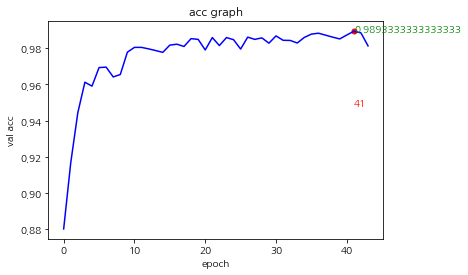

In [20]:
xrange=range(len(acc_list))
plt.plot(xrange,acc_list, "b")
plt.xlabel('epoch')
plt.ylabel('val acc')
plt.title('acc graph')
max_point=max(acc_list)
plt.scatter(acc_list.index(max_point), max_point,s= 100,c='r',marker='.')
plt.text(acc_list.index(max_point), max_point, max_point, c='g')
plt.text(acc_list.index(max_point),0.948, acc_list.index(max_point), c='r')
plt.show()

## 평가

In [22]:
from sklearn.metrics import classification_report

def test(dataloader, model, loss_fn):
    categories=[str(i) for i in range(10)]
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        cnt=0
        preds = torch.tensor([]) #예측
        targets = torch.tensor([]) #실제 정답
        
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            #클래스 별 precision-recall 계산
            predicted=pred.argmax(1) #텐서형태임
            
            print('{}번째 step\n'.format(cnt+1))
            preds=torch.cat((preds,predicted.cpu()),0)
            targets=torch.cat((targets,y.cpu()),0)
            cnt+=1
       
        report_total=classification_report(targets.cpu(),preds.cpu(), target_names=categories, zero_division=0)

    total_loss /= num_batches
    correct /= size
    
    print("-------------total classification report-------------------\n")
    print('total classes: ',categories)
    print('클래스 갯수: ', len(categories))
    
    print(report_total)
    return total_loss, correct

In [23]:
test(test_dataloader, model, loss_fn)

1번째 step

2번째 step

3번째 step

4번째 step

5번째 step

6번째 step

7번째 step

8번째 step

9번째 step

10번째 step

11번째 step

12번째 step

13번째 step

14번째 step

15번째 step

16번째 step

17번째 step

18번째 step

19번째 step

20번째 step

21번째 step

22번째 step

23번째 step

24번째 step

25번째 step

26번째 step

27번째 step

28번째 step

29번째 step

30번째 step

31번째 step

32번째 step

33번째 step

34번째 step

35번째 step

36번째 step

37번째 step

38번째 step

39번째 step

40번째 step

41번째 step

42번째 step

43번째 step

44번째 step

45번째 step

46번째 step

47번째 step

48번째 step

49번째 step

50번째 step

51번째 step

52번째 step

53번째 step

54번째 step

55번째 step

56번째 step

57번째 step

58번째 step

59번째 step

60번째 step

61번째 step

62번째 step

63번째 step

64번째 step

65번째 step

66번째 step

67번째 step

68번째 step

69번째 step

70번째 step

71번째 step

72번째 step

73번째 step

74번째 step

75번째 step

76번째 step

77번째 step

78번째 step

79번째 step

80번째 step

81번째 step

82번째 step

83번째 step

84번째 step

85번째 step

86번째 step

87번째 step

88번째 step

89번째 step

90번째 step

91번째 step

92번째 ste

(0.07188935830449418, 0.986)

In [ ]:
test_acc=0
test_loss=0
test_correct=0
with torch.no_grad():
    for X,y in tqdm(test_dataloader):
        X=X.to(device)
        y=y.to(device)
        output = model(X) # this get's the prediction from the network
        test_loss=+loss_fn(output, y).item()
        
        #acc 계산
        test_correct += (output.argmax(1) == y).type(torch.float).sum().item()
        
        
    
test_loss/=len(test_dataloader) 
test_acc=test_correct/len(test_dataloader.dataset)  

In [ ]:
test_acc

In [ ]:
fig = plt.figure(figsize=(8, 8))
cols, rows = 5,2
samples_idx=random.sample(range(len(test_data)),10)
for i in range(0, cols * rows ):
    idx=samples_idx[i]
    img,label=test_data[idx]
    fig.add_subplot(rows, cols, i+1)
    output=model(test_data[idx][0].unsqueeze(0).to(device))
    plt.title("라벨: "+str(label)+", 예측: {}".format(output.argmax().item()) )
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
    
    

In [ ]:
from PIL import Image
from torchvision import transforms
import os
root_dir="/home/files/pytorch_practice"
covert=transforms.ToTensor()
sample_1=Image.open(os.path.join(root_dir, '1sam.jpg')).convert("L")
sample_2=Image.open(os.path.join(root_dir, '6sam.jpg')).convert("L")
sample_3=Image.open(os.path.join(root_dir, '7sam.jpg')).convert("L")
sample_4=Image.open(os.path.join(root_dir, '7re.jpg')).convert("L")
samples=[sample_1,sample_2,sample_3,sample_4]
new_samples=[]
for img in samples:
    img=img.resize((28,28))
    img=convert(img)
    new_samples.append(img)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.show()
    print(f"예측값: {model(img.unsqueeze(0).to(device)).argmax().item()}")
    #print(model(img.unsqueeze(0).to(device)).max(1))